<a href="https://colab.research.google.com/github/esha1701/BloodGlucose-Prediction/blob/main/LstmUva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Data Extraction, Preprocessing & Exploration

### Loading CGM Data 

In [ ]:
# getting file containing only blood glucose values
bgdf = pd.read_csv("/content/bg-Table 1.csv")
bgdf

,type,sourceName,value,unit,startDate,endDate,creationDate,com.loopkit.InsulinKit.MetadataKeyProgrammedTempBasalRate,com.loopkit.InsulinKit.MetadataKeyScheduledBasalRate,com.loudnate.CarbKit.HKMetadataKey.AbsorptionTimeMinutes,FitzpatrickSkinType,HKMetadataKeySyncVersion,CardioFitnessMedicationsUse,sourceVersion,HasLoopKitOrigin,Transmitter Time,Status,BloodType,BiologicalSex,Trend Arrow,HKInsulinDeliveryReason,HKMetadataKeyDevicePlacementSide,com.loudnate.GlucoseKit.HKMetadataKey.GlucoseIsDisplayOnly,HKFoodType,device,DateOfBirth,HKTimeZone,HKDeviceName,Trend Rate,HKWasUserEntered,HKMetadataKeySyncIdentifier
0,BloodGlucose,Loop,126,mg/dL,11/1/21 0:05,11/1/21 0:05,11/1/21 0:05,NaN,NaN,NaN,NaN,1.0,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,"<<HKDevice: 0x28014c000>, name:CGMBLEKit, manu...",NaN,NaN,NaN,NaN,NaN,8MB5QB 3729973
1,BloodGlucose,Loop,126,mg/dL,11/1/21 0:00,11/1/21 0:00,11/1/21 0:00,NaN,NaN,NaN,NaN,1.0,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,"<<HKDevice: 0x28014c000>, name:CGMBLEKit, manu...",NaN,NaN,NaN,NaN,NaN,8MB5QB 3729673
2,BloodGlucose,Loop,121,mg/dL,10/31/21 23:55,10/31/21 23:55,10/31/21 23:55,NaN,NaN,NaN,NaN,1.0,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,"<<HKDevice: 0x28014c000>, name:CGMBLEKit, manu...",NaN,NaN,NaN,NaN,NaN,8MB5QB 3729373
3,BloodGlucose,Loop,122,mg/dL,10/31/21 23:50,10/31/21 23:50,10/31/21 23:50,NaN,NaN,NaN,NaN,1.0,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,"<<HKDevice: 0x28014c000>, name:CGMBLEKit, manu...",NaN,NaN,NaN,NaN,NaN,8MB5QB 3729073
4,BloodGlucose,Loop,123,mg/dL,10/31/21 23:45,10/31/21 23:45,10/31/21 23:45,NaN,NaN,NaN,NaN,1.0,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,"<<HKDevice: 0x28014c000>, name:CGMBLEKit, manu...",NaN,NaN,NaN,NaN,NaN,8MB5QB 3728773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65529,BloodGlucose,Dexcom G6,132,mg/dL,3/10/21 16:37,3/10/21 16:37,3/10/21 19:42,NaN,NaN,NaN,NaN,NaN,NaN,16629,NaN,2021-03-10 20:37:01 +0000,IN_RANGE,NaN,NaN,Flat,NaN,NaN,NaN,NaN,NaN,NaN,America/New_York,1.038627e+13,0.2,NaN,NaN
65530,BloodGlucose,Dexcom G6,129,mg/dL,3/10/21 16:32,3/10/21 16:32,3/10/21 19:37,NaN,NaN,NaN,NaN,NaN,NaN,16629,NaN,2021-03-10 20:32:01 +0000,IN_RANGE,NaN,NaN,Flat,NaN,NaN,NaN,NaN,NaN,NaN,America/New_York,1.038627e+13,-0.2,NaN,NaN
65531,BloodGlucose,Dexcom G6,128,mg/dL,3/10/21 16:27,3/10/21 16:27,3/10/21 19:32,NaN,NaN,NaN,NaN,NaN,NaN,16629,NaN,2021-03-10 20:27:01 +0000,IN_RANGE,NaN,NaN,Flat,NaN,NaN,NaN,NaN,NaN,NaN,America/New_York,1.038627e+13,0.0,NaN,NaN
65532,BloodGlucose,Dexcom G6,129,mg/dL,3/10/21 16:22,3/10/21 16:22,3/10/21 19:27,NaN,NaN,NaN,NaN,NaN,NaN,16629,NaN,2021-03-10 20:22:01 +0000,IN_RANGE,NaN,NaN,Flat,NaN,NaN,NaN,NaN,NaN,NaN,America/New_York,1.038627e+13,0.0,NaN,NaN


We are only interested in the timestamps and value of blood glucose values. The rest of the columns are all internal [Loop ](https://loopkit.github.io/loopdocs/)states which can be dropped.

In [ ]:
# We only need time & bg values, rest of the column are internal loop states 
bgdf = bgdf[["startDate","value"]]
bgdf['startDate'] = pd.to_datetime(bgdf['startDate']) 
bgdf

,startDate,value
0,2021-11-01 00:05:00,126
1,2021-11-01 00:00:00,126
2,2021-10-31 23:55:00,121
3,2021-10-31 23:50:00,122
4,2021-10-31 23:45:00,123
...,...,...
65529,2021-03-10 16:37:00,132
65530,2021-03-10 16:32:00,129
65531,2021-03-10 16:27:00,128
65532,2021-03-10 16:22:00,129


### Blood Glucose Stats

In [ ]:
maxBG = bgdf['value'].max()
minBG = bgdf['value'].min()
meanBG = bgdf['value'].mean()
stdBG = bgdf['value'].std()

print('Maximum blood glucose:', maxBG, 'mg/dl')
print('Minimum blood glucose:', minBG,'mg/dl')
print('Mean blood glucose:', meanBG,'mg/dl')
print('Standard deviation:', stdBG,'mg/dl')

Maximum blood glucose: 262 mg/dl
Minimum blood glucose: 39 mg/dl
Mean blood glucose: 116.70767845698415 mg/dl
Standard deviation: 25.835676287466875 mg/dl


Hyperglycemic threshold is 180mg/dl and hypoglycemic threshold 70mg/dl.

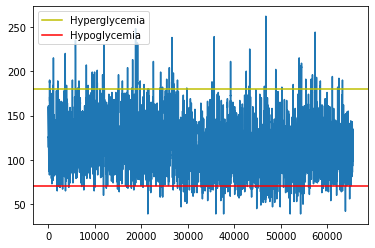

In [ ]:

plt.plot(bgdf['value'])
plt.axhline(y = 180, color = 'y', linestyle = '-',label = 'Hyperglycemia')
plt.axhline(y = 70, color = 'r', linestyle = '-', label = 'Hypoglycemia')
plt.legend()



### Loading Carbohydrate Data

In [ ]:
carbsdf = pd.read_csv("carbs-Table 1.csv")
carbsdf


,type,sourceName,value,unit,startDate,endDate,creationDate,com.loopkit.InsulinKit.MetadataKeyProgrammedTempBasalRate,com.loopkit.InsulinKit.MetadataKeyScheduledBasalRate,com.loudnate.CarbKit.HKMetadataKey.AbsorptionTimeMinutes,FitzpatrickSkinType,HKMetadataKeySyncVersion,CardioFitnessMedicationsUse,sourceVersion,HasLoopKitOrigin,Transmitter Time,Status,BloodType,BiologicalSex,Trend Arrow,HKInsulinDeliveryReason,HKMetadataKeyDevicePlacementSide,com.loudnate.GlucoseKit.HKMetadataKey.GlucoseIsDisplayOnly,HKFoodType,device,DateOfBirth,HKTimeZone,HKDeviceName,Trend Rate,HKWasUserEntered,HKMetadataKeySyncIdentifier
0,DietaryCarbohydrates,Loop,113.0,g,10/31/21 22:10,10/31/21 22:10,10/31/21 22:10,NaN,NaN,14400,NaN,1,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,salad cb,NaN,NaN,NaN,NaN,NaN,NaN,FFA616A1-0FF5-42CE-8169-CFF32DDC5234
1,DietaryCarbohydrates,Loop,41.0,g,10/31/21 19:00,10/31/21 19:00,10/31/21 19:00,NaN,NaN,10800,NaN,1,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,grapes c&c pbj,NaN,NaN,NaN,NaN,NaN,NaN,F00BAD19-691F-40B0-89D0-6E494EA03E28
2,DietaryCarbohydrates,Loop,41.0,g,10/31/21 10:02,10/31/21 10:02,10/31/21 10:02,NaN,NaN,7200,NaN,1,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,grapes c&c,NaN,NaN,NaN,NaN,NaN,NaN,A3AD5E02-9EDA-4B31-A75E-F79D28C761A8
3,DietaryCarbohydrates,Loop,129.0,g,10/30/21 22:43,10/30/21 22:43,10/30/21 22:44,NaN,NaN,14400,NaN,1,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eggs rolls pbj,NaN,NaN,NaN,NaN,NaN,NaN,D449FC63-5104-4D4E-998D-44DCE4C89294
4,DietaryCarbohydrates,Loop,41.0,g,10/30/21 18:53,10/30/21 18:53,10/30/21 18:54,NaN,NaN,10800,NaN,1,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,grapes c&c pbj,NaN,NaN,NaN,NaN,NaN,NaN,646F79C0-A8B5-4132-8F8B-8BE5C3C892F6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,DietaryCarbohydrates,Loop,98.0,g,11/27/20 23:20,11/27/20 23:20,11/27/20 23:22,NaN,NaN,10800,NaN,1,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"salad cornbread 92,111",NaN,NaN,NaN,NaN,NaN,NaN,9D494DA8-6B7E-4544-BC69-57F18DC9392C
1276,DietaryCarbohydrates,Loop,16.0,g,11/27/20 21:05,11/27/20 21:05,11/27/20 21:07,NaN,NaN,10800,NaN,1,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1/2 juice c&c grapes,NaN,NaN,NaN,NaN,NaN,NaN,B41CEC83-04D5-4D83-AA9C-E3FBAA7C84CB
1277,DietaryCarbohydrates,Loop,16.0,g,11/27/20 13:18,11/27/20 13:18,11/27/20 13:27,NaN,NaN,10800,NaN,2,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"c&c, grapes",NaN,NaN,NaN,NaN,NaN,NaN,9834704F-BA5C-4DDF-BCB5-29CE2134A291
1278,DietaryCarbohydrates,Loop,16.0,g,11/27/20 10:36,11/27/20 10:36,11/27/20 13:27,NaN,NaN,7200,NaN,2,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,juice bottle,NaN,NaN,NaN,NaN,NaN,NaN,BDA0B662-6BD4-4398-A21E-27A22558A9DA


Again, dropping internal Loop states and keeping only the timestamps and carbohydrate intake values.

In [ ]:
carbsdf = carbsdf[["startDate","value"]]
carbsdf ['startDate'] = pd.to_datetime(carbsdf ['startDate'])
carbsdf

,startDate,value
0,2021-10-31 22:10:00,113.0
1,2021-10-31 19:00:00,41.0
2,2021-10-31 10:02:00,41.0
3,2021-10-30 22:43:00,129.0
4,2021-10-30 18:53:00,41.0
...,...,...
1275,2020-11-27 23:20:00,98.0
1276,2020-11-27 21:05:00,16.0
1277,2020-11-27 13:18:00,16.0
1278,2020-11-27 10:36:00,16.0


### Carbohydrate Intake Stats

In [ ]:
Cdays = carbsdf['startDate'][0] - carbsdf['startDate'][len(carbsdf)-1]
avgmeals = len(carbsdf)/Cdays.days
"Average number of meals per day:", avgmeals

('Average number of meals per day:', 3.78698224852071)

In [ ]:
max_carbs= carbsdf['value'].max()
'Maximum Carbs:', max_carbs, 'g'

('Maximum Carbs:', 140.0, 'g')

## Loading Insulin Data

In [ ]:
insulindf = pd.read_csv("insulin-Table 1.csv")
insulindf

,type,sourceName,value,unit,startDate,endDate,creationDate,com.loopkit.InsulinKit.MetadataKeyProgrammedTempBasalRate,com.loopkit.InsulinKit.MetadataKeyScheduledBasalRate,com.loudnate.CarbKit.HKMetadataKey.AbsorptionTimeMinutes,FitzpatrickSkinType,HKMetadataKeySyncVersion,CardioFitnessMedicationsUse,sourceVersion,HasLoopKitOrigin,Transmitter Time,Status,BloodType,BiologicalSex,Trend Arrow,HKInsulinDeliveryReason,HKMetadataKeyDevicePlacementSide,com.loudnate.GlucoseKit.HKMetadataKey.GlucoseIsDisplayOnly,HKFoodType,device,DateOfBirth,HKTimeZone,HKDeviceName,Trend Rate,HKWasUserEntered,HKMetadataKeySyncIdentifier
0,InsulinDelivery,Loop,0.05,IU,10/31/21 23:55,10/31/21 23:55,11/1/21 0:00,NaN,NaN,NaN,NaN,1,NaN,57,1,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,"<<HKDevice: 0x280148050>, name:Omnipod, manufa...",NaN,NaN,NaN,NaN,NaN,626f6c757320302e303520323032312d31312d30315430...
1,InsulinDelivery,Loop,0.10,IU,10/31/21 23:40,10/31/21 23:40,10/31/21 23:50,NaN,NaN,NaN,NaN,1,NaN,57,1,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,"<<HKDevice: 0x280148050>, name:Omnipod, manufa...",NaN,NaN,NaN,NaN,NaN,626f6c757320302e3120323032312d31312d3031543033...
2,InsulinDelivery,Loop,0.00,IU,10/31/21 23:05,10/31/21 23:25,10/31/21 23:25,0 IU/hr,0.4 IU/hr,NaN,NaN,1,NaN,57,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,"<<HKDevice: 0x280148050>, name:Omnipod, manufa...",NaN,NaN,NaN,NaN,NaN,74656d70426173616c20302e3020323032312d31312d30...
3,InsulinDelivery,Loop,0.00,IU,10/31/21 23:05,10/31/21 23:05,10/31/21 23:25,NaN,NaN,NaN,NaN,1,NaN,57,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,"<<HKDevice: 0x280148050>, name:Omnipod, manufa...",NaN,NaN,NaN,NaN,NaN,BasalRateSchedule 2021-11-01T03:05:36Z 2021-11...
4,InsulinDelivery,Loop,0.00,IU,10/31/21 22:45,10/31/21 23:05,10/31/21 23:05,0 IU/hr,0.4 IU/hr,NaN,NaN,1,NaN,57,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,"<<HKDevice: 0x280148050>, name:Omnipod, manufa...",NaN,NaN,NaN,NaN,NaN,74656d70426173616c20302e3020323032312d31312d30...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47969,InsulinDelivery,Loop,0.80,IU,11/27/20 5:00,11/27/20 6:00,11/27/20 9:52,NaN,NaN,NaN,NaN,1,NaN,57,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,"<<HKDevice: 0x280154320>, name:Omnipod, manufa...",NaN,NaN,NaN,NaN,NaN,BasalRateSchedule 2020-11-27T09:00:00Z 2020-11...
47970,InsulinDelivery,Loop,1.70,IU,11/27/20 3:00,11/27/20 5:00,11/27/20 9:52,NaN,NaN,NaN,NaN,1,NaN,57,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,"<<HKDevice: 0x280154320>, name:Omnipod, manufa...",NaN,NaN,NaN,NaN,NaN,BasalRateSchedule 2020-11-27T07:00:00Z 2020-11...
47971,InsulinDelivery,Loop,0.80,IU,11/27/20 2:00,11/27/20 3:00,11/27/20 9:52,NaN,NaN,NaN,NaN,1,NaN,57,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,"<<HKDevice: 0x280154320>, name:Omnipod, manufa...",NaN,NaN,NaN,NaN,NaN,BasalRateSchedule 2020-11-27T06:00:00Z 2020-11...
47972,InsulinDelivery,Loop,0.75,IU,11/27/20 1:00,11/27/20 2:00,11/27/20 9:52,NaN,NaN,NaN,NaN,1,NaN,57,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,"<<HKDevice: 0x280154320>, name:Omnipod, manufa...",NaN,NaN,NaN,NaN,NaN,BasalRateSchedule 2020-11-27T05:00:00Z 2020-11...


In [ ]:
bolusdf = insulindf[['startDate','endDate','value']]
bolusdf['startDate'] =  pd.to_datetime(insulindf['startDate'])
bolusdf['endDate'] =  pd.to_datetime(insulindf['endDate'])
time_duration = bolusdf['endDate'] - bolusdf['startDate']
time_duration = time_duration.dt.seconds
bolusdf['time_duration(sec)'] = time_duration 
bolusdf

,startDate,endDate,value,time_duration(sec)
0,2021-10-31 23:55:00,2021-10-31 23:55:00,0.05,0
1,2021-10-31 23:40:00,2021-10-31 23:40:00,0.10,0
2,2021-10-31 23:05:00,2021-10-31 23:25:00,0.00,1200
3,2021-10-31 23:05:00,2021-10-31 23:05:00,0.00,0
4,2021-10-31 22:45:00,2021-10-31 23:05:00,0.00,1200
...,...,...,...,...
47969,2020-11-27 05:00:00,2020-11-27 06:00:00,0.80,3600
47970,2020-11-27 03:00:00,2020-11-27 05:00:00,1.70,7200
47971,2020-11-27 02:00:00,2020-11-27 03:00:00,0.80,3600
47972,2020-11-27 01:00:00,2020-11-27 02:00:00,0.75,3600


We add an extra column ``` time_duration ``` which calculates how long an insulin dose was given for. We only want to consider boluses in our model so we drop all rows which have an insulin dose less than 0.6 IU or took over 10 minutes to deliver.





In [ ]:
# Dropping basal values
basal_val1 = bolusdf[bolusdf['value']<0.6 ].index
bolusdf.drop(basal_val1 , inplace=True)
basal_val2 = bolusdf[bolusdf['time_duration(sec)']>600].index
bolusdf.drop(basal_val2 , inplace=True)
bolusdf = bolusdf.drop(['time_duration(sec)','endDate'],axis=1)

In [ ]:
bolusdf

,startDate,value
7,2021-10-31 22:10:00,3.75
18,2021-10-31 19:00:00,1.55
67,2021-10-31 10:02:00,1.60
129,2021-10-30 22:44:00,4.25
149,2021-10-30 18:54:00,1.65
...,...,...
47924,2020-11-28 21:13:00,7.30
47938,2020-11-28 16:44:00,2.40
47941,2020-11-28 14:53:00,1.10
47948,2020-11-28 05:13:00,1.65


### Bolus Stats

In [ ]:
Bdays = bolusdf['startDate'][7] - bolusdf['startDate'][47954]
avgbolus = len(bolusdf)/Bdays.days
"Average number of boluses per day:", avgbolus


('Average number of boluses per day:', 2.4688427299703264)

In [ ]:
"Average bolus units:", bolusdf['value'].mean()

('Average bolus units:', 3.2859975961538477)

In [ ]:
max_bolus= bolusdf['value'].max()
'Maximum Bolus:', max_bolus, 'units'

('Maximum Bolus:', 10.8, 'units')

Currently we have three separate tables for blood glucose, carbohydrates and insulin. We need to get all of them in a single table, with values of bg, carbs and bolus for every single timestamp (i.e. for ever 5 minute interval). Since CGM sensors have to be changed every 10 days and have a 2 hour warmup period, there are gaps in the time intervals. Thus, we create a new dataframe with 5 minute time intervals. 

In [ ]:
import pandas as pd
timestamps = pd.date_range('2021-03-11','2021-10-31', freq='5min')
timedf = pd.DataFrame({'startDate':timestamps})
timedf

,startDate
0,2021-03-11 00:00:00
1,2021-03-11 00:05:00
2,2021-03-11 00:10:00
3,2021-03-11 00:15:00
4,2021-03-11 00:20:00
...,...
67388,2021-10-30 23:40:00
67389,2021-10-30 23:45:00
67390,2021-10-30 23:50:00
67391,2021-10-30 23:55:00


Merging the data in each of the 3 tables to the closest 5 minute timestamp.

In [ ]:
#pandas.merge_asof only works on sorted dataframes
bgdf = bgdf[::-1]
bolusdf = bolusdf[::-1]
carbsdf = carbsdf[::-1]

In [ ]:
datadf = pd.merge_asof(timedf, bgdf, on="startDate", tolerance=pd.Timedelta('5min'))
datadf = pd.merge_asof(datadf, carbsdf, on="startDate", tolerance=pd.Timedelta('5min'))
datadf = pd.merge_asof(datadf, bolusdf, on="startDate", tolerance=pd.Timedelta('5min'))
datadf = datadf.rename(columns={"value_x": "BG", "value_y": "Carbs","value": "Bolus",'startDate':'DateTime'})
datadf

,DateTime,BG,Carbs,Bolus
0,2021-03-11 00:00:00,100.0,NaN,NaN
1,2021-03-11 00:05:00,99.0,NaN,NaN
2,2021-03-11 00:10:00,100.0,NaN,NaN
3,2021-03-11 00:15:00,102.0,NaN,NaN
4,2021-03-11 00:20:00,104.0,NaN,NaN
...,...,...,...,...
67388,2021-10-30 23:40:00,156.0,NaN,NaN
67389,2021-10-30 23:45:00,154.0,NaN,NaN
67390,2021-10-30 23:50:00,156.0,NaN,NaN
67391,2021-10-30 23:55:00,158.0,NaN,NaN


We get the missing blood glucose values through linear interpolation and set carb & bolus values to 0 for the timestamps with no entries.

In [ ]:
datadf['BG']= datadf['BG'].interpolate(method='linear')
datadf['Carbs'] = datadf['Carbs'].fillna(0)
datadf['Bolus'] = datadf['Bolus'].fillna(0)
datadf[-30:-10]

,DateTime,BG,Carbs,Bolus
67363,2021-10-30 21:35:00,162.0,0.0,0.00
67364,2021-10-30 21:40:00,163.0,0.0,0.00
67365,2021-10-30 21:45:00,163.0,0.0,0.00
67366,2021-10-30 21:50:00,169.0,0.0,0.00
67367,2021-10-30 21:55:00,170.0,0.0,0.00
67368,2021-10-30 22:00:00,171.0,0.0,0.00
67369,2021-10-30 22:05:00,168.0,0.0,0.00
67370,2021-10-30 22:10:00,166.0,0.0,0.00
67371,2021-10-30 22:15:00,164.0,0.0,0.00
67372,2021-10-30 22:20:00,165.0,0.0,0.00


In [ ]:
datadf = datadf.drop(['DateTime'],axis = 1)
data_as_np = datadf.to_numpy()
data_as_np

array([[100.,   0.,   0.],
       [ 99.,   0.,   0.],
       [100.,   0.,   0.],
       ...,
       [156.,   0.,   0.],
       [158.,   0.,   0.],
       [158.,   0.,   0.]])

Plotting 288 readings to get the graph for blood glucose, bolus and carboydrate values for 24 hours.


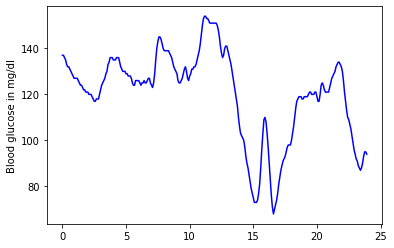

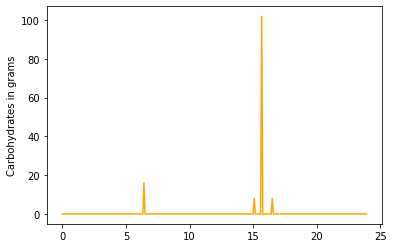

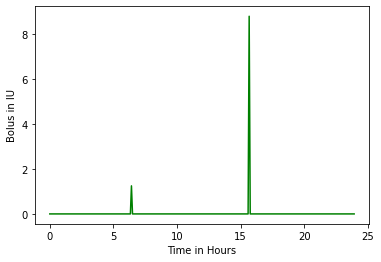

In [ ]:
t = [i*5/60 for i in range(0,288)]
plt.plot(t, data_as_np[9000:9288,0],color='blue')
plt.ylabel("Blood glucose in mg/dl")
plt.show()
plt.plot(t, data_as_np[9000:9288,1],color='orange')
plt.ylabel("Carbohydrates in grams")
plt.show()
plt.plot(t, data_as_np[9000:9288,2],color='green')
plt.xlabel('Time in Hours')
plt.ylabel("Bolus in IU")
plt.show()

 

## Model Training

We will be using 2 hour history of blood glucose values, carbs and bolus to forecast 60 minute blood glucose values in the future.

In [ ]:
def np_to_X_y(data, window_size, future_steps):
  """
  Function to input and output data arrays for LSTM model
  params:
    data (array)       : numpy array containing bg value, carbs and insulin  
    window_size (int)  : number of previous timesteps/memory needed for prediction
    future_steps (int) : number of timesteps for prediction   

  returns:
    X (np.array)      : input array having previous 120 minute bg value, carbs, insulin
    y (np.array)      : output array having next 60 minute bg values
  """
  X = []
  y = []
  for i in range(len(data)-window_size-future_steps-1):
    row = [a for a in data[i:i+window_size]]
    X.append(row)
    label = [data[j][0] for j in range(i+window_size,i+window_size+future_steps)]
    y.append(label)
  return np.asarray(X).astype(np.float32),  np.asarray(y).astype(np.float32)

In [ ]:
# Creating input & labels for LSTM 
history = 24 #120/5
future = 12 #60/5
X, y = np_to_X_y(data_as_np, history, future)
X.shape, y.shape

((67356, 24, 3), (67356, 12))

Splitting data into train, validation and testset.

In [ ]:
X_train, y_train = X[:35000], y[:35000]
X_val, y_val = X[35000:50000], y[35000:50000]
X_test,y_test = X[50000:], y[50000:]
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(35000, 24, 3) (35000, 12) (15000, 24, 3) (15000, 12) (17356, 24, 3) (17356, 12)


In [ ]:
X_train, y_train

(array([[[100.,   0.,   0.],
         [ 99.,   0.,   0.],
         [100.,   0.,   0.],
         ...,
         [140.,   0.,   0.],
         [143.,   0.,   0.],
         [143.,   0.,   0.]],
 
        [[ 99.,   0.,   0.],
         [100.,   0.,   0.],
         [102.,   0.,   0.],
         ...,
         [143.,   0.,   0.],
         [143.,   0.,   0.],
         [140.,   0.,   0.]],
 
        [[100.,   0.,   0.],
         [102.,   0.,   0.],
         [104.,   0.,   0.],
         ...,
         [143.,   0.,   0.],
         [140.,   0.,   0.],
         [137.,   0.,   0.]],
 
        ...,
 
        [[156.,   0.,   0.],
         [155.,   0.,   0.],
         [154.,   0.,   0.],
         ...,
         [126.,   0.,   0.],
         [125.,   0.,   0.],
         [125.,   0.,   0.]],
 
        [[155.,   0.,   0.],
         [154.,   0.,   0.],
         [152.,   0.,   0.],
         ...,
         [125.,   0.,   0.],
         [125.,   0.,   0.],
         [126.,   0.,   0.]],
 
        [[154.,   0.,   0.],
 


On running multiple experiments and hyperparameter tuning, we find that the best network structure is a LSTM layer of 70 units with a relu activation function. The MSE objective is minimized using Adam and a learning rate of 0.0001. 

In [ ]:
model = Sequential()
model.add(LSTM(70,activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dense(future))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 70)                20720     
                                                                 
 dense (Dense)               (None, 12)                852       
                                                                 
Total params: 21,572
Trainable params: 21,572
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp1 = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp1])

Epoch 1/20
1091/1094 [============================>.] - ETA: 0s - loss: 6413.5176 - root_mean_squared_error: 80.0845INFO:tensorflow:Assets written to: model/assets


1094/1094 [==============================] - 17s 14ms/step - loss: 6399.1265 - root_mean_squared_error: 79.9946 - val_loss: 791.3763 - val_root_mean_squared_error: 28.1314
Epoch 2/20
1090/1094 [============================>.] - ETA: 0s - loss: 632.4599 - root_mean_squared_error: 25.1488INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1094/1094 [==============================] - 16s 14ms/step - loss: 631.9368 - root_mean_squared_error: 25.1384 - val_loss: 623.4811 - val_root_mean_squared_error: 24.9696
Epoch 3/20
1094/1094 [==============================] - ETA: 0s - loss: 376.4576 - root_mean_squared_error: 19.4025INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1094/1094 [==============================] - 16s 14ms/step - loss: 376.4576 - root_mean_squared_error: 19.4025 - val_loss: 390.4117 - val_root_mean_squared_error: 19.7588
Epoch 4/20
1092/1094 [============================>.] - ETA: 0s - loss: 264.5521 - root_mean_squared_error: 16.2651INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1094/1094 [==============================] - 15s 14ms/step - loss: 264.4395 - root_mean_squared_error: 16.2616 - val_loss: 282.1005 - val_root_mean_squared_error: 16.7958
Epoch 5/20
1091/1094 [============================>.] - ETA: 0s - loss: 215.8644 - root_mean_squared_error: 14.6923INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1094/1094 [==============================] - 16s 14ms/step - loss: 215.7509 - root_mean_squared_error: 14.6885 - val_loss: 264.6688 - val_root_mean_squared_error: 16.2686
Epoch 6/20
1090/1094 [============================>.] - ETA: 0s - loss: 303.5605 - root_mean_squared_error: 17.4230INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1094/1094 [==============================] - 17s 15ms/step - loss: 303.3889 - root_mean_squared_error: 17.4181 - val_loss: 252.4706 - val_root_mean_squared_error: 15.8893
Epoch 7/20
1092/1094 [============================>.] - ETA: 0s - loss: 203.8873 - root_mean_squared_error: 14.2789INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1094/1094 [==============================] - 16s 14ms/step - loss: 203.8283 - root_mean_squared_error: 14.2768 - val_loss: 223.9297 - val_root_mean_squared_error: 14.9643
Epoch 8/20
1091/1094 [============================>.] - ETA: 0s - loss: 180.5475 - root_mean_squared_error: 13.4368INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1094/1094 [==============================] - 16s 14ms/step - loss: 180.5420 - root_mean_squared_error: 13.4366 - val_loss: 203.8595 - val_root_mean_squared_error: 14.2779
Epoch 9/20
1090/1094 [============================>.] - ETA: 0s - loss: 169.0735 - root_mean_squared_error: 13.0028INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1094/1094 [==============================] - 16s 15ms/step - loss: 169.0142 - root_mean_squared_error: 13.0005 - val_loss: 194.0354 - val_root_mean_squared_error: 13.9297
Epoch 10/20
1091/1094 [============================>.] - ETA: 0s - loss: 161.6279 - root_mean_squared_error: 12.7133INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1094/1094 [==============================] - 18s 16ms/step - loss: 161.5607 - root_mean_squared_error: 12.7107 - val_loss: 189.6676 - val_root_mean_squared_error: 13.7720
Epoch 11/20
1094/1094 [==============================] - 15s 13ms/step - loss: 158.8025 - root_mean_squared_error: 12.6017 - val_loss: 199.6329 - val_root_mean_squared_error: 14.1292
Epoch 12/20
1094/1094 [==============================] - 14s 13ms/step - loss: 155.0807 - root_mean_squared_error: 12.4531 - val_loss: 190.0686 - val_root_mean_squared_error: 13.7865
Epoch 13/20
1090/1094 [============================>.] - ETA: 0s - loss: 150.4440 - root_mean_squared_error: 12.2656INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1094/1094 [==============================] - 16s 14ms/step - loss: 150.4589 - root_mean_squared_error: 12.2662 - val_loss: 182.6512 - val_root_mean_squared_error: 13.5149
Epoch 14/20
1094/1094 [==============================] - 14s 13ms/step - loss: 152.4060 - root_mean_squared_error: 12.3453 - val_loss: 186.1734 - val_root_mean_squared_error: 13.6445
Epoch 15/20
1092/1094 [============================>.] - ETA: 0s - loss: 146.2848 - root_mean_squared_error: 12.0948INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1094/1094 [==============================] - 16s 15ms/step - loss: 146.1989 - root_mean_squared_error: 12.0913 - val_loss: 178.4869 - val_root_mean_squared_error: 13.3599
Epoch 16/20
1094/1094 [==============================] - 14s 13ms/step - loss: 143.7690 - root_mean_squared_error: 11.9904 - val_loss: 180.8790 - val_root_mean_squared_error: 13.4491
Epoch 17/20
1090/1094 [============================>.] - ETA: 0s - loss: 141.8525 - root_mean_squared_error: 11.9102INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1094/1094 [==============================] - 16s 14ms/step - loss: 141.6990 - root_mean_squared_error: 11.9037 - val_loss: 172.9211 - val_root_mean_squared_error: 13.1499
Epoch 18/20
1094/1094 [==============================] - 14s 13ms/step - loss: 143.6989 - root_mean_squared_error: 11.9874 - val_loss: 176.5816 - val_root_mean_squared_error: 13.2884
Epoch 19/20
1094/1094 [==============================] - 14s 13ms/step - loss: 142.0913 - root_mean_squared_error: 11.9202 - val_loss: 172.9265 - val_root_mean_squared_error: 13.1502
Epoch 20/20
1094/1094 [==============================] - 14s 13ms/step - loss: 140.1272 - root_mean_squared_error: 11.8375 - val_loss: 181.1310 - val_root_mean_squared_error: 13.4585


The number of train epochs was 20 iterations. After 20 epochs, the validation error did not come down with increasing epochs.

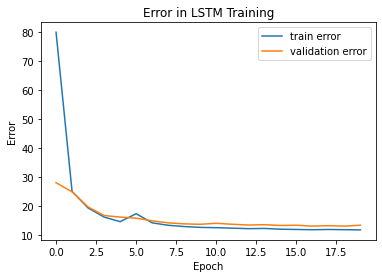

In [ ]:
plt.plot(history.history['root_mean_squared_error'], label='train error')
plt.plot(history.history['val_root_mean_squared_error'], label='validation error')
plt.title("Error in LSTM Training")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()
plt.show()

## Results

Root mean squared error can be a catastrophic evaluation metric for blood glucose predictions. It doesn't help if you are a 100% accurate half of the time and completely off the other half. So we need to find better ways to evaluate accuracy of predictions. One way implemented here is by plotting random 60 minute predictions, since that is what the patient at the user end would see it make treatment decisions. 

In [ ]:
def plotBG(index, predictions, true):

  """
  Function to compare 60 minute prediction and true blood glucose values.
  Params:
    index (int)          : Index of prediction array i.e. time instance of prediction
    predictions (array)  : LSTM model bg predictions
    true (array)         : True bg values 

  """

  time = [i for i in range(5,65,5)]
  plt.plot(time, predictions[index],'r',label='Prediction')
  plt.plot(time, true[index],label='True')
  plt.ylim(60,200)
  plt.xlabel('Time in minutes')
  plt.ylabel('BG in mg/dl')
  plt.legend()
  pddata= pd.DataFrame(data={'Predictions': predictions[index], 'Actuals':true[index]})
  print(pddata)
  rmse = math.sqrt(mean_squared_error(predictions[index], true[index]))
  print("Root Mean Squared Error: ",rmse)

### Train Results

In [ ]:
train_predictions = model.predict(X_train)
train_results = pd.DataFrame(data={'Train Predictions':train_predictions.flatten(), 'True Value':y_train.flatten()})
train_results

,Train Predictions,True Value
0,140.712158,140.0
1,140.640976,137.0
2,139.106842,136.0
3,140.758850,137.0
4,139.544235,139.0
...,...,...
419995,122.659653,134.0
419996,123.182701,136.0
419997,120.885559,138.0
419998,120.791039,139.0


In [ ]:
rmse = math.sqrt(mean_squared_error(y_train,train_predictions))
rmse

11.92143278689197

    Predictions  Actuals
0    140.743393    143.0
1    141.887772    142.0
2    140.963882    141.0
3    139.028687    140.0
4    138.262756    139.0
5    136.951233    138.0
6    135.655151    138.0
7    134.428680    139.0
8    134.688690    138.0
9    132.370377    134.0
10   131.027161    132.0
11   130.199677    131.0
Root Mean Squared Error:  2.0268144743543126


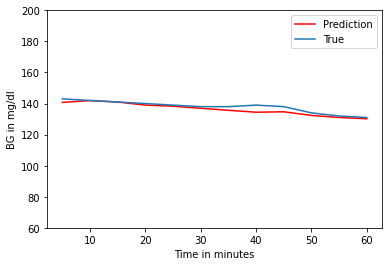

In [ ]:
plotBG(10, train_predictions, y_train)

    Predictions  Actuals
0     89.460907     88.0
1     88.337372     84.0
2     87.147369     83.0
3     87.437035     84.0
4     86.776825     86.0
5     86.622513     87.0
6     87.126366     87.0
7     87.239601     85.0
8     87.734894     83.0
9     87.255333     82.0
10    86.865715     82.0
11    88.311516     83.0
Root Mean Squared Error:  3.624727436210398


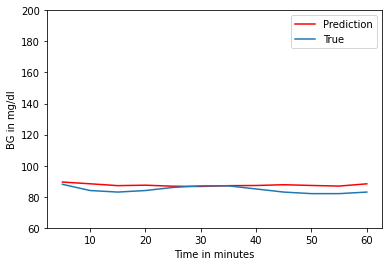

In [ ]:
plotBG(89, train_predictions, y_train)


### Validation Results

In [ ]:
val_predictions = model.predict(X_val)
val_results = pd.DataFrame(data={'Val Predictions':val_predictions.flatten(), 'True Value':y_val.flatten()})
val_results

,Val Predictions,True Value
0,131.950043,130.0
1,131.813080,127.0
2,130.282440,126.0
3,130.238113,126.0
4,128.543808,129.0
...,...,...
179995,130.526627,121.0
179996,132.527664,121.0
179997,130.061798,121.0
179998,129.906174,119.0


In [ ]:
rmse = math.sqrt(mean_squared_error(y_val,val_predictions))
rmse

13.458477448596293

    Predictions  Actuals
0    112.452324    111.0
1    110.943268    112.0
2    109.273277    113.0
3    111.216263    114.0
4    108.638947    116.0
5    107.007866    119.0
6    108.450302    122.0
7    106.110252    127.0
8    106.420166    127.0
9    106.407745    126.0
10   106.724762    125.0
11   104.824242    124.0
Root Mean Squared Error:  13.99974986261613


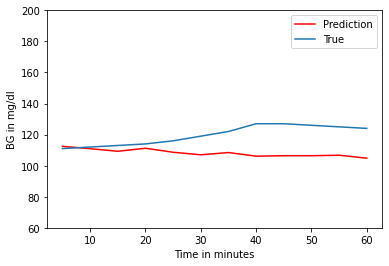

In [ ]:
plotBG(27, val_predictions, y_val)


    Predictions  Actuals
0    100.113457    100.0
1     99.595329     99.0
2     97.405609     98.0
3     96.493652     96.0
4     95.424416     94.0
5     94.354881     92.0
6     93.963936     90.0
7     95.211342     88.0
8     94.008133     86.0
9     92.687500     85.0
10    91.675819     84.0
11    92.439384     84.0
Root Mean Squared Error:  5.241057454636216


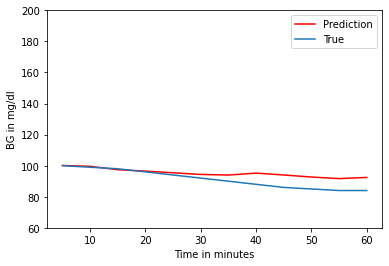

In [ ]:
plotBG(2000, val_predictions, y_val)

### Test Results

In [ ]:
test_predictions = model.predict(X_test)
test_results = pd.DataFrame(data={'Test Predictions':test_predictions.flatten(), 'True Value':y_test.flatten()})
test_results

,Test Predictions,True Value
0,123.593048,125.0
1,121.494370,122.0
2,118.156891,120.0
3,118.084122,118.0
4,115.889511,121.0
...,...,...
208267,124.112701,147.0
208268,122.108116,153.0
208269,121.999107,156.0
208270,115.534058,154.0


In [ ]:
rmse = math.sqrt(mean_squared_error(y_test,test_predictions))
rmse

13.752047854426252

    Predictions  Actuals
0    126.899490    124.0
1    125.766228    119.0
2    119.827461    121.0
3    128.319229    124.0
4    123.328041    127.0
5    123.904976    129.0
6    123.374931    130.0
7    124.280869    126.0
8    119.583679    124.0
9    123.015060    124.0
10   121.469315    127.0
11   123.070488    137.0
Root Mean Squared Error:  5.813796688360692


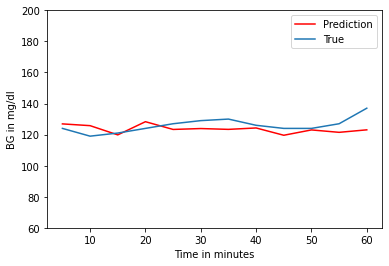

In [ ]:
plotBG(6000, test_predictions, y_test)

    Predictions  Actuals
0    132.142670    132.0
1    131.700455    136.0
2    130.326370    144.0
3    130.296143    150.0
4    128.371902    135.0
5    126.262543    132.0
6    126.057091    129.0
7    125.721710    128.0
8    125.022316    128.0
9    125.127251    127.0
10   124.302650    127.0
11   121.190155    125.0
Root Mean Squared Error:  7.738337447738895


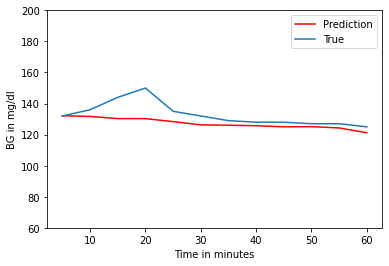

In [ ]:
plotBG(8907, test_predictions, y_test)

### Clarke Error Grid Analysis

A measure of clinical accuracy is the Clarke Error Grid Analysis. It describes the impact a blood glucose prediction would have on a treatment decision.

In [ ]:
def clarke_error_grid(ref_values, pred_values, title_string):

    #Checking to see if the lengths of the reference and prediction arrays are the same
    assert (len(ref_values) == len(pred_values)), "Unequal number of values (reference : {}) (prediction : {}).".format(len(ref_values), len(pred_values))

   
    #Clear plot
    plt.clf()

    #Set up plot
    plt.scatter(ref_values, pred_values, marker='.', color='pink', s=8)
    plt.title(title_string + " Clarke Error Grid",fontsize=12 )
    plt.xlabel("True BG (mg/dl)", fontsize=12 )
    plt.ylabel("Prediction BG (mg/dl)",fontsize=12 )
    plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.gca().set_facecolor('white')

    #Set axes lengths
    plt.gca().set_xlim([0, 400])
    plt.gca().set_ylim([0, 400])
    plt.gca().set_aspect((400)/(400))




    #Plot zone lines
    plt.plot([0,400], [0,400], ':', c='black')                     
    plt.plot([0, 175/3], [70, 70], '-', c='black')
    plt.plot([175/3, 400/1.2], [70, 400], '-', c='black')          
    plt.plot([70, 70], [84, 400],'-', c='black')
    plt.plot([0, 70], [180, 180], '-', c='black')
    plt.plot([70, 290],[180, 400],'-', c='black')
    plt.plot([70, 70], [0, 56], '-', c='black')                    
    plt.plot([70, 400], [56, 320],'-', c='black')
    plt.plot([180, 180], [0, 70], '-', c='black')
    plt.plot([180, 400], [70, 70], '-', c='black')
    plt.plot([240, 240], [70, 180],'-', c='black')
    plt.plot([240, 400], [180, 180], '-', c='black')
    plt.plot([130, 180], [0, 70], '-', c='black')

    #Add zone titles
    plt.text(30, 15, "A", fontsize=15)
    plt.text(370, 260, "B", fontsize=15)
    plt.text(280, 370, "B", fontsize=15)
    plt.text(160, 370, "C", fontsize=15)
    plt.text(160, 15, "C", fontsize=15)
    plt.text(30, 140, "D", fontsize=15)
    plt.text(370, 120, "D", fontsize=15)
    plt.text(30, 370, "E", fontsize=15)
    plt.text(370, 15, "E", fontsize=15)

    #Statistics from the data
    zone = [0] * 5
    for i in range(len(ref_values)):
        if (ref_values[i] <= 70 and pred_values[i] <= 70) or (pred_values[i] <= 1.2*ref_values[i] and pred_values[i] >= 0.8*ref_values[i]):
            zone[0] += 1    #Zone A

        elif (ref_values[i] >= 180 and pred_values[i] <= 70) or (ref_values[i] <= 70 and pred_values[i] >= 180):
            zone[4] += 1    #Zone E

        elif ((ref_values[i] >= 70 and ref_values[i] <= 290) and pred_values[i] >= ref_values[i] + 110) or ((ref_values[i] >= 130 and ref_values[i] <= 180) and (pred_values[i] <= (7/5)*ref_values[i] - 182)):
            zone[2] += 1    #Zone C
        elif (ref_values[i] >= 240 and (pred_values[i] >= 70 and pred_values[i] <= 180)) or (ref_values[i] <= 175/3 and pred_values[i] <= 180 and pred_values[i] >= 70) or ((ref_values[i] >= 175/3 and ref_values[i] <= 70) and pred_values[i] >= (6/5)*ref_values[i]):
            zone[3] += 1    #Zone D
        else:
            zone[1] += 1    #Zone B

    plt.show()
    print('Zone A:',zone[0])
    print('Zone B:',zone[1])
    print('Zone C:',zone[2])
    print('Zone D:',zone[3])
    print('Zone E:',zone[4])
    #Source: https://github.com/suetAndTie/ClarkeErrorGrid/blob/master/ClarkeErrorGrid.py



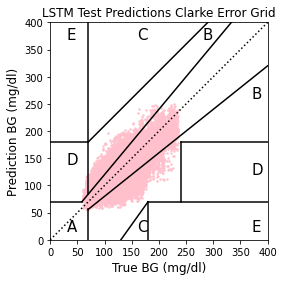

Zone A: 192723
Zone B: 15229
Zone C: 0
Zone D: 320
Zone E: 0


In [ ]:
clarke_error_grid(y_test.flatten(), test_predictions.flatten(),'LSTM Test Predictions')

## UVA/Padova Simulation

The UVA/Padova simulator is a physiological model that describes the interaction of glucose and insulin within different subsystems in the human body and returns the instantaneous state of the variables in those subsystems.
<img width="5cm">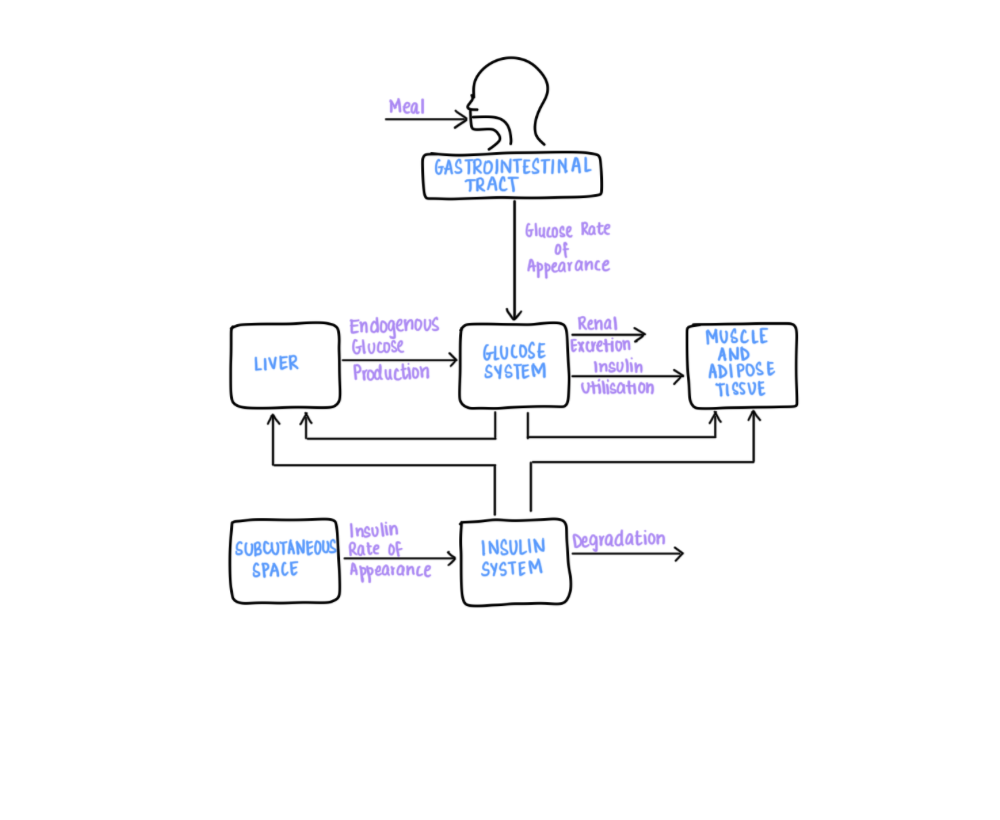

The equations for the model are as follows (and are implemnted in ODE.py):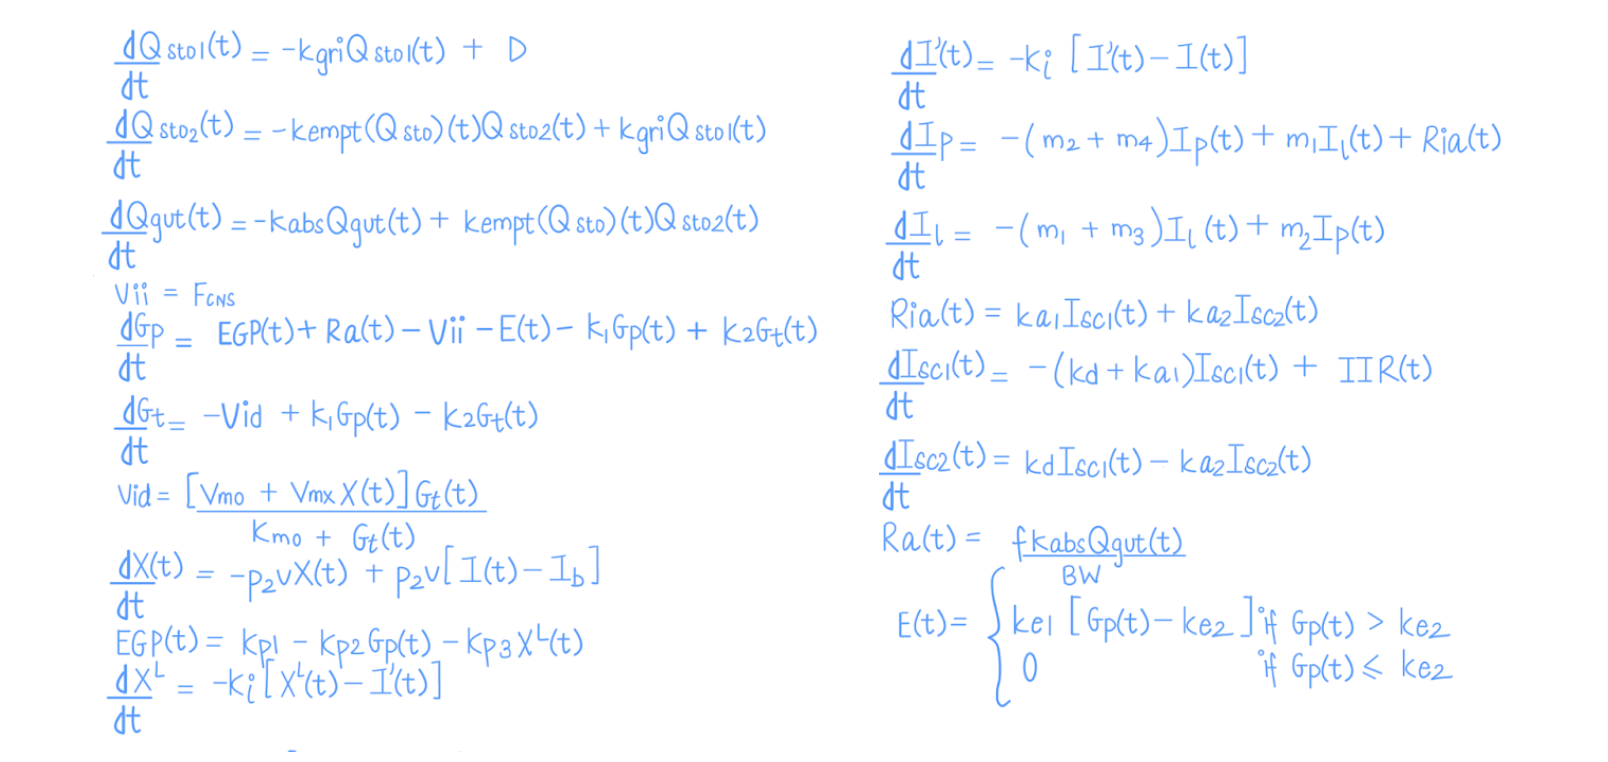

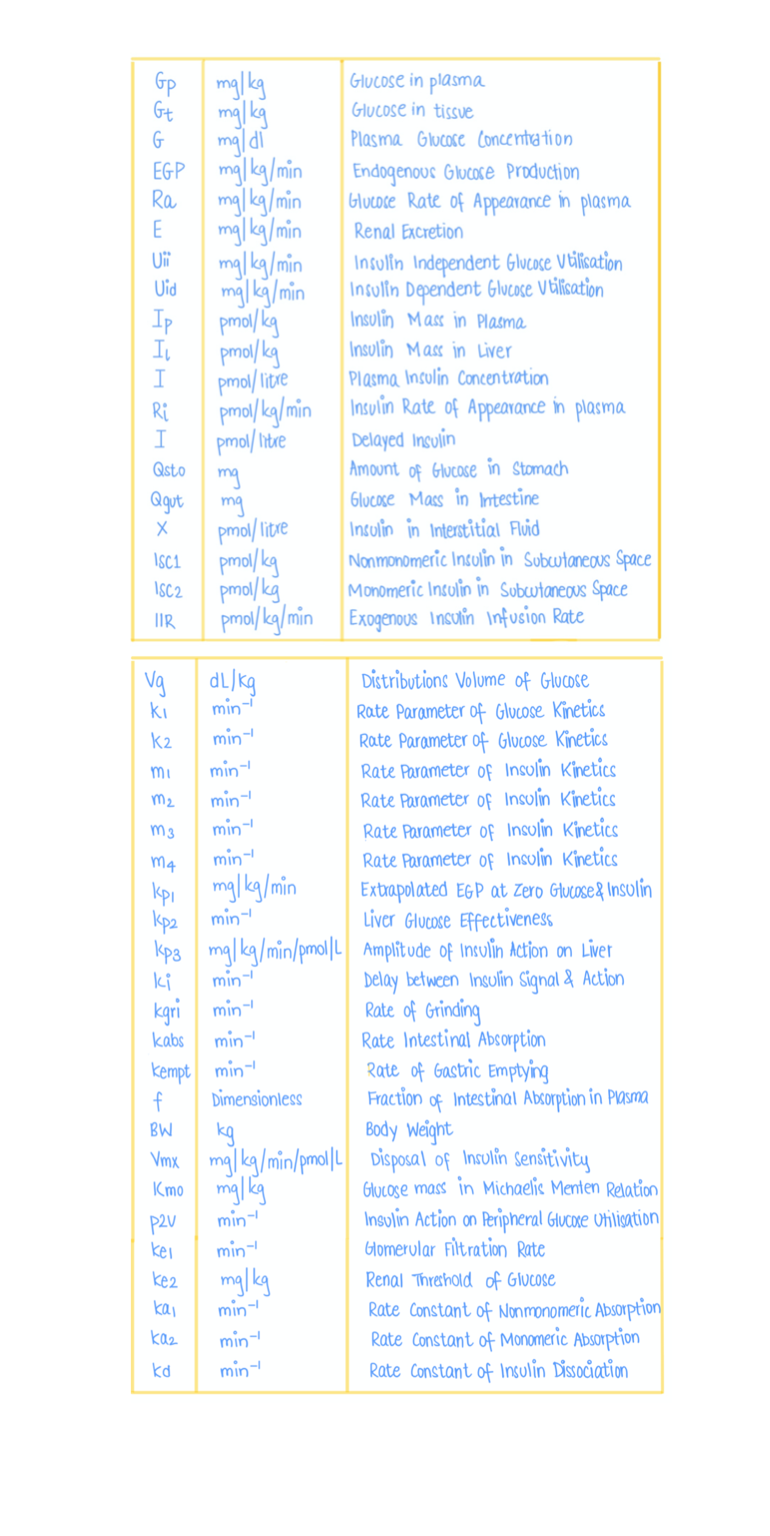

In [ ]:
import run

In [ ]:
#plotting a few random post meal scenarios 
def UVAsim(i):
  Gb, carbs, bolus = X_test[i][23][0], X_test[i][23][1], X_test[i][23][2]
  #print('Start Glucose',Gb,'\nCarbs',carbs, '\nBolus',bolus)
  pred = run.simulator(Gb,0.3,carbs,bolus)
  return pred[1:-1:5]

Since the UVA/Padova simulator was built for post prandial simulations, we only use it for ```X_test```values where there is some carbohydrate intake. Therefore, here we create a new y test set ```truepred_arr``` with only post prandial predictions.



In [ ]:
UVApred_arr = []
truepred_arr = []
pp_test = []
for i in range(len(X_test)):
  if X_test[i][23][1]!=0: 
    pp_test.append(X_test[i])
    UVApred_arr.append(UVAsim(i))
    truepred_arr.append(y_test[i])

UVApred_arr = np.array(UVApred_arr)
truepred_arr = np.array(truepred_arr)
pp_test = np.array(pp_test)

### Results

In [ ]:
rmse = math.sqrt(mean_squared_error(UVApred_arr,truepred_arr))
rmse

33.466919956641895

In [ ]:
lstmpp_pred = model.predict(np.reshape(pp_test,(len(pp_test),24,3)))
rmse = math.sqrt(mean_squared_error(lstmpp_pred,truepred_arr))
rmse

17.79212530588717

In [ ]:
def compare(lstm_val, UVA_val, true):
  time_array = [i for i in range(5,65,5)]
  results = pd.DataFrame(data={'Time in min':time_array, 'UVA/Padova Predictions':UVA_val, 'LSTM Predictions':lstm_val.flatten(), 'True Value':true})
  print(results)
  plt.plot(time_array,UVA_val)
  plt.plot(time_array,lstm_val,'r')
  plt.plot(time_array,true)
  plt.ylim(60,200)
  plt.xlabel("Time in minutes")
  plt.ylabel("BG in mg/dl")
  plt.legend(['UVA/Padova','LSTM','True'])
  plt.show()



    Time in min  UVA/Padova Predictions  LSTM Predictions  True Value
0             5              113.475476        110.858047       108.0
1            10              123.288614        109.856049       104.0
2            15              130.300415        104.869247       105.0
3            20              135.766373        108.418633       112.0
4            25              140.355840        107.431633       119.0
5            30              144.421745        110.430725       123.0
6            35              148.150685        109.801682       127.0
7            40              151.641955        118.311737       133.0
8            45              154.949098        116.947815       137.0
9            50              158.101730        117.856354       136.0
10           55              161.117018        113.355988       133.0
11           60              164.005682        119.706253       131.0


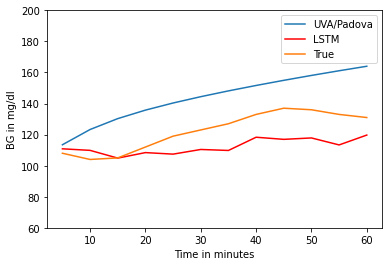

In [ ]:
UVApred1 = UVAsim(16917)
lstm_pred1 = model.predict(np.reshape(X_test[16917],(1,24,3)))
compare(lstm_pred1.flatten(), UVApred1, y_test[16917].flatten())

    Time in min  UVA/Padova Predictions  LSTM Predictions  True Value
0             5              116.451453        114.824753       113.0
1            10              126.149395        114.899612       113.0
2            15              133.074619        113.958977       112.0
3            20              138.509155        110.236153       110.0
4            25              143.125246        104.081573       108.0
5            30              147.264347         99.226837       104.0
6            35              151.098917         95.890663       100.0
7            40              154.715634         93.852737        99.0
8            45              158.157971         88.274635       101.0
9            50              161.447946         84.697502        99.0
10           55              164.597169         83.089897        96.0
11           60              167.612411         82.164749        89.0


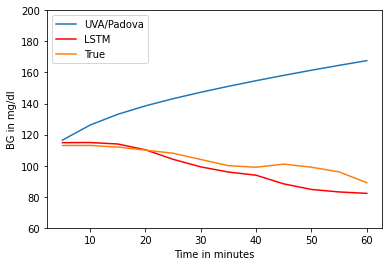

In [ ]:
UVApred2 = UVAsim(9874)
lstm_pred2 = model.predict(np.reshape(X_test[9874],(1,24,3)))
compare(lstm_pred2.flatten(), UVApred2, y_test[9874].flatten())

    Time in min  UVA/Padova Predictions  LSTM Predictions  True Value
0             5               81.732520         81.789619        77.0
1            10               92.832323         82.938362        80.0
2            15              101.098123         83.517517        90.0
3            20              107.745482         85.764801        98.0
4            25              113.429538         89.128098       101.0
5            30              118.505841         91.470657        98.0
6            35              123.169622         92.193024        94.0
7            40              127.530104         98.659782        96.0
8            45              131.650174         99.013069        98.0
9            50              135.567601        101.302338       101.0
10           55              139.306412         96.918228       106.0
11           60              142.883001        100.492088       108.0


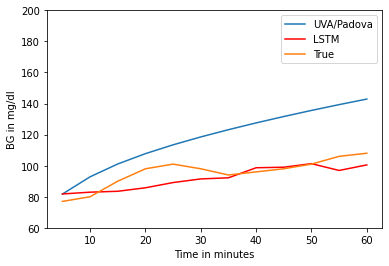

In [ ]:
UVApred3 = UVAsim(404)
lstm_pred3 = model.predict(np.reshape(X_test[404],(1,24,3)))
compare(lstm_pred3.flatten(), UVApred3, y_test[404].flatten())

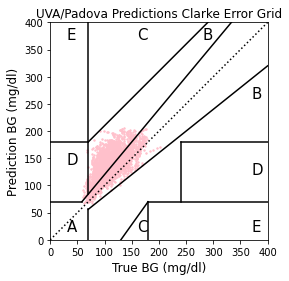

Zone A: 1397
Zone B: 1660
Zone C: 0
Zone D: 39
Zone E: 0


In [ ]:
clarke_error_grid(truepred_arr.flatten(), UVApred_arr.flatten(),'UVA/Padova Predictions')